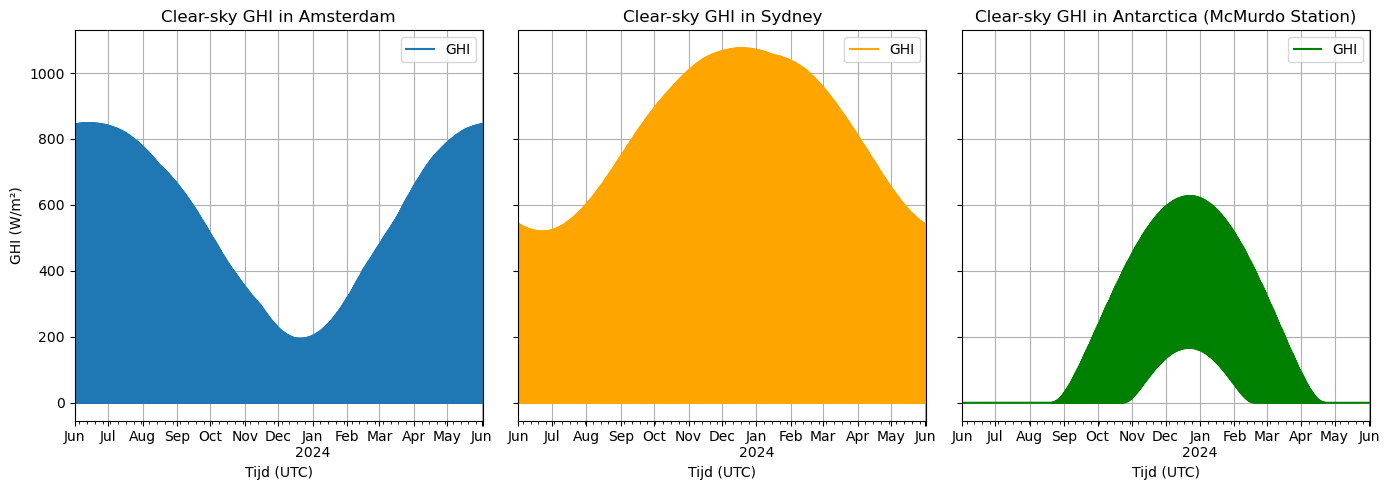

In [1]:
import pvlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pvlib.location import Location

# Gegevens voor Amsterdam
latitude_amsterdam = 52.3676
longitude_amsterdam = 4.9041
timezone_amsterdam = 'Europe/Amsterdam'
name_amsterdam = 'Amsterdam'

# Gegevens voor Sydney
latitude_sydney = -33.8688
longitude_sydney = 151.2093
timezone_sydney = 'Australia/Sydney'
name_sydney = 'Sydney'

# Gegevens voor McMurdo Station, Antarctica
latitude_antarctica = -77.8419
longitude_antarctica = 166.6863
timezone_antarctica = 'Antarctica/McMurdo'
name_antarctica = 'Antarctica (McMurdo Station)'


# Initialiseer locaties
location_amsterdam = Location(latitude=latitude_amsterdam, longitude=longitude_amsterdam, tz=timezone_amsterdam, name=name_amsterdam)
location_sydney = Location(latitude=latitude_sydney, longitude=longitude_sydney, tz=timezone_sydney, name=name_sydney)
location_antarctica = Location(latitude=latitude_antarctica, longitude=longitude_antarctica, tz=timezone_antarctica, name=name_antarctica)

# Definieer de tijdstippen in UTC
times = pd.date_range(start='2023-06-01', end='2024-06-02', freq='1H', tz='UTC')

# Bereken de zonnepositie
solar_position_amsterdam = location_amsterdam.get_solarposition(times)
solar_position_sydney = location_sydney.get_solarposition(times)
solar_position_antarctica = location_antarctica.get_solarposition(times)

# Bereken de clear-sky straling met het Ineichen-model
clearsky_amsterdam = location_amsterdam.get_clearsky(times, model='ineichen')
clearsky_sydney = location_sydney.get_clearsky(times, model='ineichen')
clearsky_antarctica = location_antarctica.get_clearsky(times, model='ineichen')

# Creëer een figure met twee subplots naast elkaar
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)
plt.grid(True)
# Plot voor Amsterdam
clearsky_amsterdam['ghi'].plot(ax=axes[0], label='GHI')
axes[0].grid(True)
axes[0].set_ylabel('GHI (W/m²)')
axes[0].set_xlabel('Tijd (UTC)')
axes[0].set_title('Clear-sky GHI in {}'.format(name_amsterdam))
axes[0].legend()

# Plot voor Sydney
clearsky_sydney['ghi'].plot(ax=axes[1], label='GHI', color='orange')
axes[1].grid(True)
axes[1].set_ylabel('GHI (W/m²)')
axes[1].set_xlabel('Tijd (UTC)')
axes[1].set_title('Clear-sky GHI in {}'.format(name_sydney))
axes[1].legend()

# Plot voor Antarctica
clearsky_antarctica['ghi'].plot(ax=axes[2], label='GHI', color='green')
axes[2].grid(True)
axes[2].set_ylabel('GHI (W/m²)')
axes[2].set_xlabel('Tijd (UTC)')
axes[2].set_title('Clear-sky GHI in {}'.format(name_antarctica))
axes[2].legend()

plt.tight_layout()
plt.show()

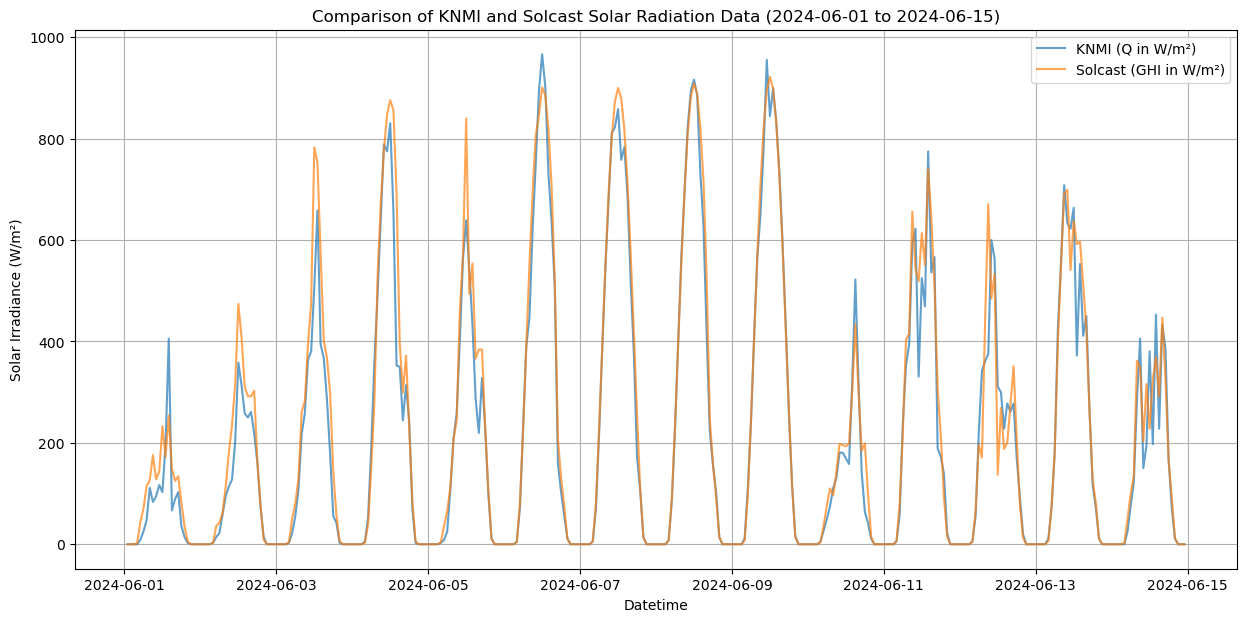

In [2]:
import Weer_data_inladen

# Load KNMI and Solcast data
knmi_data = Weer_data_inladen.load_knmi_data('data/KNMI_weerdata.txt')
solcast_data = Weer_data_inladen.load_solcast_data('data/Solcast_data_2.csv')

Weer_data_inladen.plot_comparison(knmi_data, solcast_data, '2024-06-01', '2024-06-15')

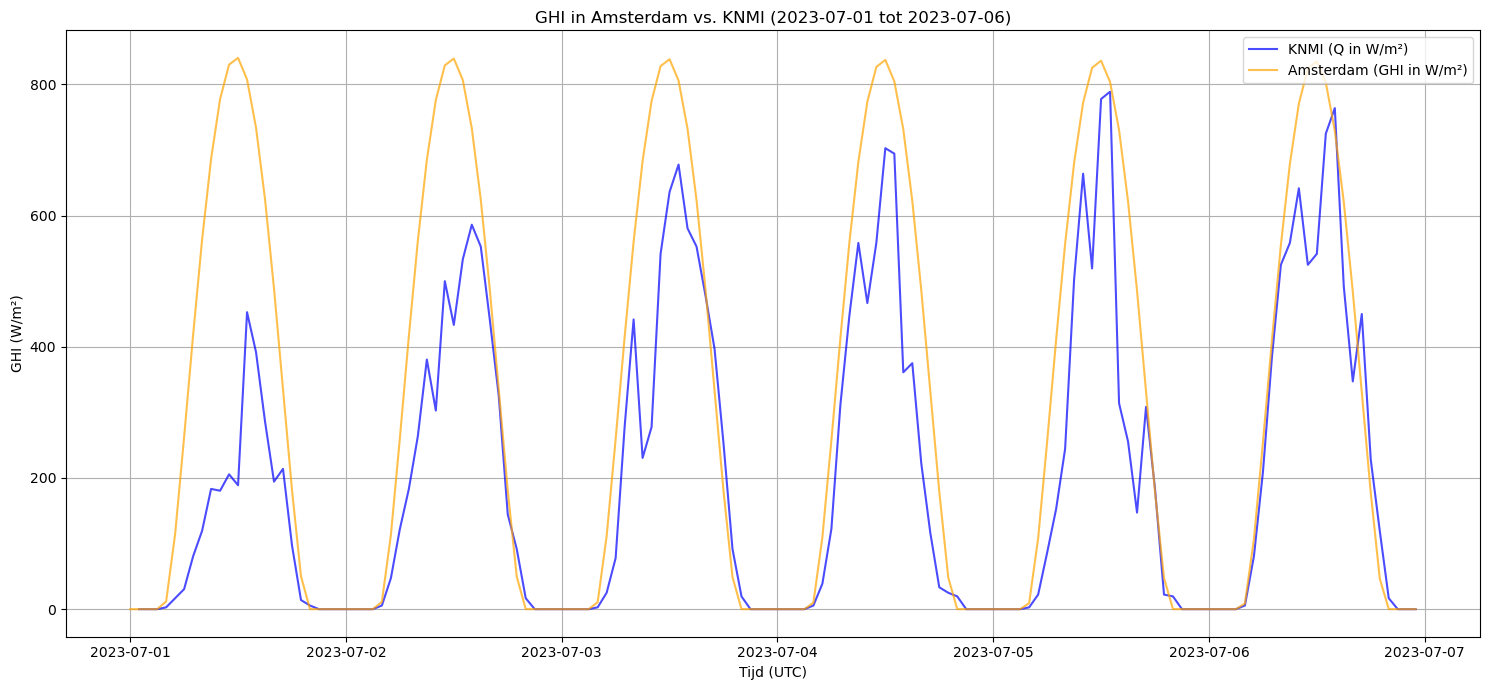

In [7]:
def plot_simulation_knmi(knmi_data, simulation_data, start_date, end_date):
    """
    Plot KNMI data en Amsterdam data in een bepaalde tijdsperiode.

    Args:
        knmi_data (pd.DataFrame): DataFrame met KNMI data, met een datetime-kolom.
        amsterdam_data (pd.DataFrame): DataFrame met Amsterdam data, met datetime als index.
        start_date (str): Startdatum in 'YYYY-MM-DD' formaat.
        end_date (str): Einddatum in 'YYYY-MM-DD' formaat.

    Returns:
        None
    """
    try:
        # Zorg dat KNMI-data een datetime-index heeft
        knmi_data.set_index('datetime', inplace=True)

        # Filter data binnen de tijdsperiode
        knmi_filtered = knmi_data.loc[start_date:end_date].copy()
        simulation_data = simulation_data.loc[start_date:end_date].copy()

        # Controleer of data beschikbaar is
        if knmi_filtered.empty or simulation_data.empty:
            print("Geen data beschikbaar in de opgegeven periode.")
            return

        # Plot de data
        plt.figure(figsize=(15, 7))
        plt.plot(knmi_filtered.index, knmi_filtered['Q_Wm2'], label='KNMI (Q in W/m²)', color='blue', alpha=0.7)
        plt.plot(simulation_data.index, simulation_data['ghi'], label='Amsterdam (GHI in W/m²)', color='orange', alpha=0.7)
        plt.xlabel('Tijd (UTC)')
        plt.ylabel('GHI (W/m²)')
        plt.title(f'GHI in Amsterdam vs. KNMI ({start_date} tot {end_date})')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Fout bij het plotten: {e}")

# Aanroepen van de functie
plot_simulation_knmi(knmi_data, clearsky_amsterdam, '2023-07-01', '2023-07-06')


In [16]:
def plot_simulation_knmi_tegenelkaar(knmi_data, simulation_data, start_date, end_date):
    """
    Plot KNMI data en simulatie data in een bepaalde tijdsperiode.

    Args:
        knmi_data (pd.DataFrame): DataFrame met KNMI data, met datetime als index.
        simulation_data (pd.DataFrame): DataFrame met simulatie data, met datetime als index.
        start_date (str): Startdatum in 'YYYY-MM-DD' formaat.
        end_date (str): Einddatum in 'YYYY-MM-DD' formaat.

    Returns:
        None
    """
    try:
        # Zorg dat beide DataFrames datetime-indexen hebben
        if 'datetime' in knmi_data.columns:
            knmi_data.set_index('datetime', inplace=True)

        # Synchroniseer indexen van beide datasets
        common_index = knmi_data.index.intersection(simulation_data.index)
        knmi_data = knmi_data.loc[common_index]
        simulation_data = simulation_data.loc[common_index]

        # Filter data binnen de tijdsperiode
        knmi_filtered = knmi_data[start_date:end_date]
        simulation_filtered = simulation_data[start_date:end_date]

        # Controleer of data beschikbaar is
        if knmi_filtered.empty or simulation_filtered.empty:
            print("Geen data beschikbaar in de opgegeven periode.")
            return

        # Plot de data
        plt.figure(figsize=(15, 7))
        plt.scatter(simulation_filtered['ghi'], knmi_filtered['Q_Wm2'], label='KNMI (Q in W/m²)', color='blue', alpha=0.7)
        #plot y=x line
        plt.plot([0, 1000], [0, 1000], color='black', linestyle='--', linewidth=1)
        plt.xlabel('GHI in Amsterdam (W/m²)')
        plt.ylabel('GHI in KNMI (W/m²)')
        plt.title(f'GHI in Simulatie vs. KNMI ({start_date} tot {end_date})')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Fout bij het plotten: {e}")


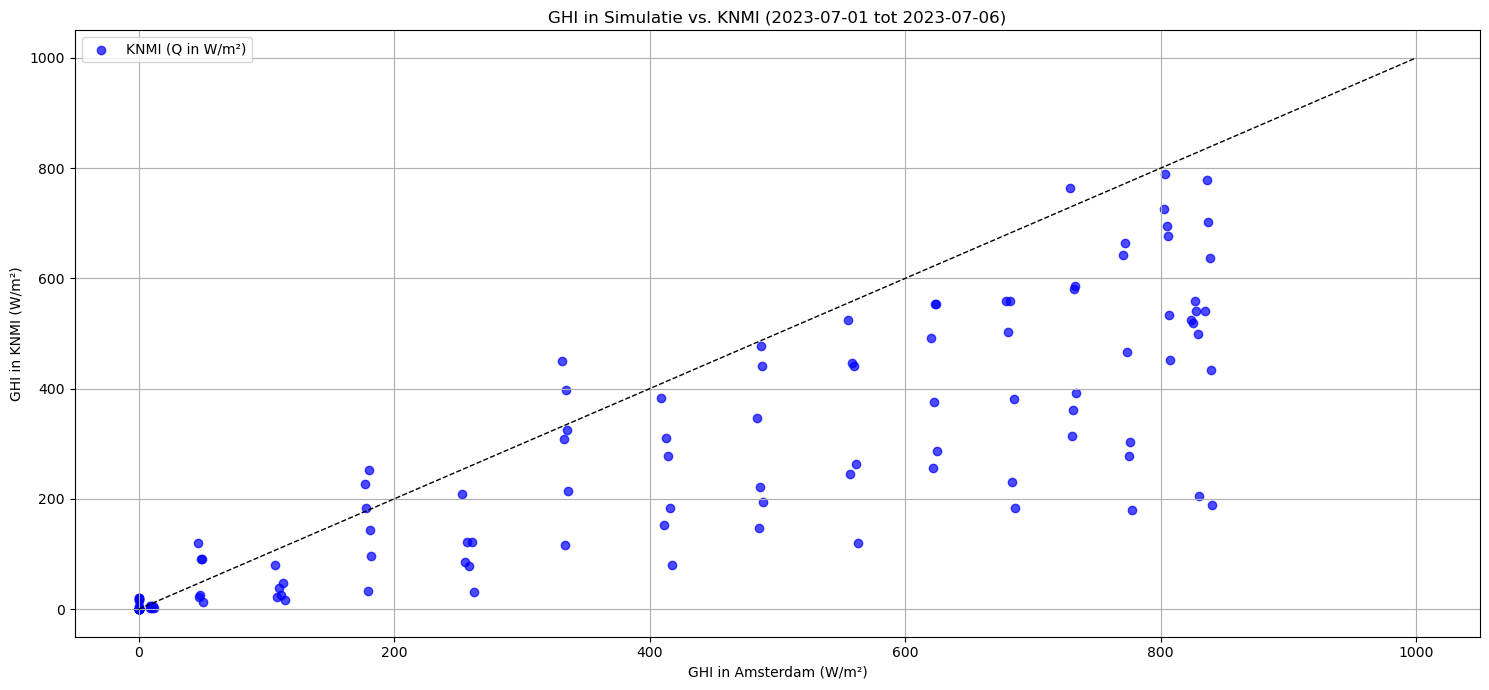

In [17]:
plot_simulation_knmi_tegenelkaar(knmi_data.copy(), clearsky_amsterdam.copy(), '2023-07-01', '2023-07-06')

Totale jaarlijkse energieopbrengst:
Amsterdam: 408.79 kWh
Sydney: 495.38 kWh
Antarctica: 333.01 kWh


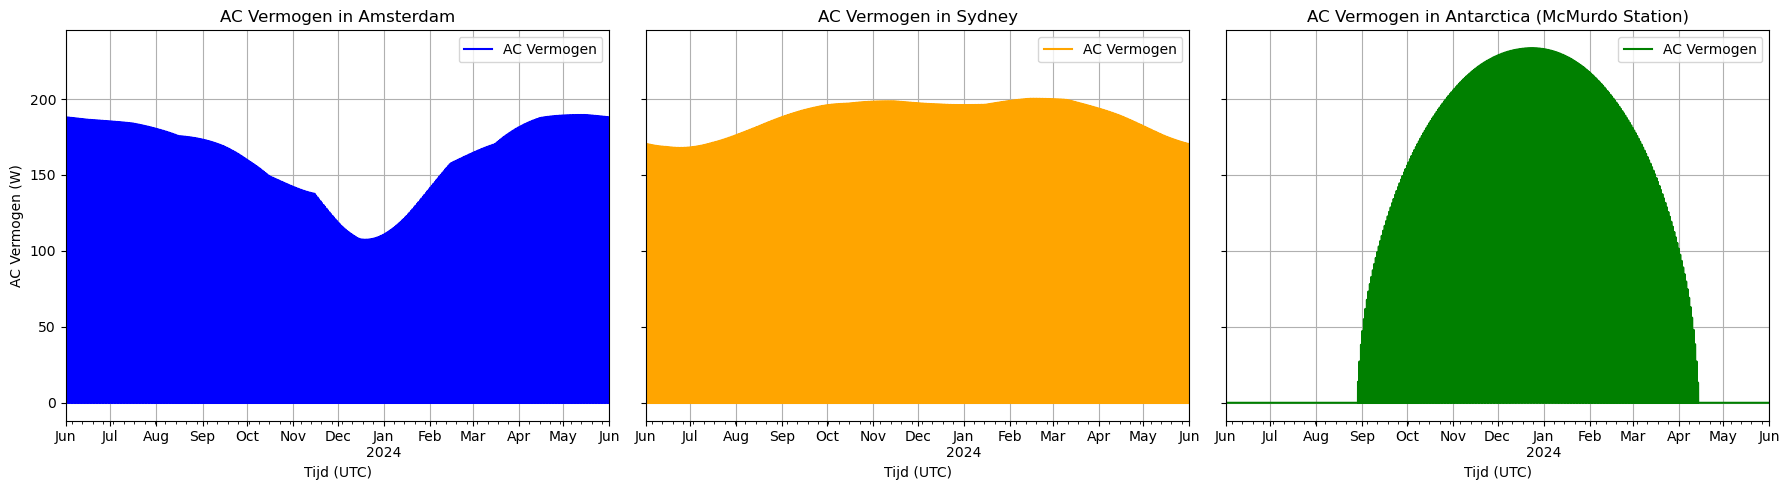

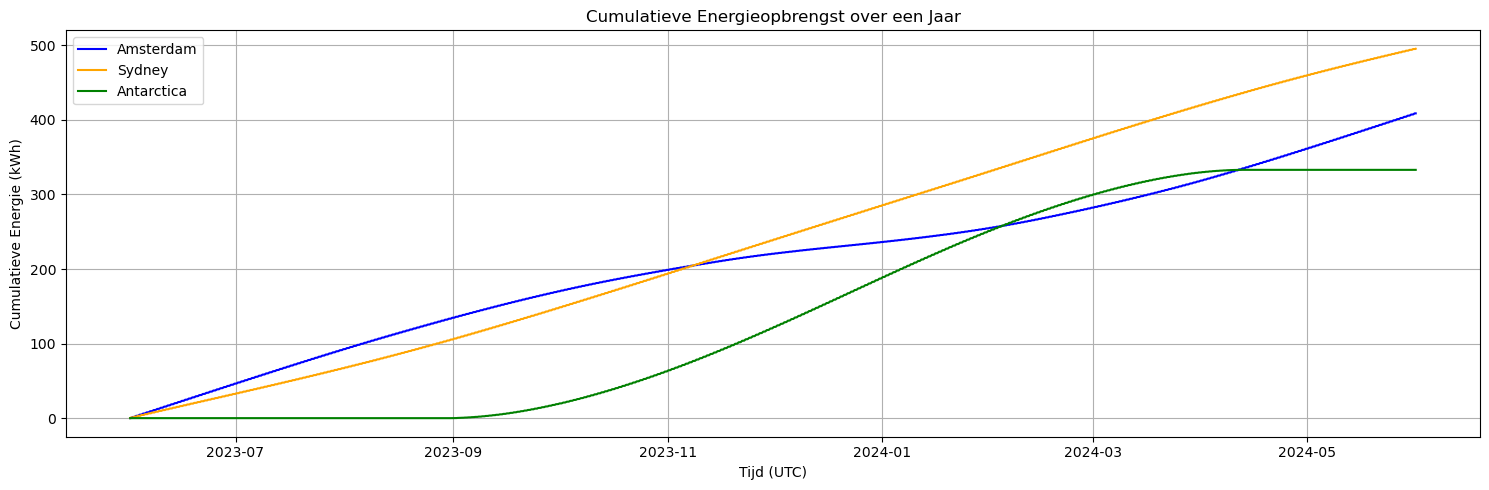

In [10]:
import pvlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pvlib.location import Location

# Gegevens voor Amsterdam
latitude_amsterdam = 52.3676
longitude_amsterdam = 4.9041
timezone_amsterdam = 'Europe/Amsterdam'
name_amsterdam = 'Amsterdam'

# Gegevens voor Sydney
latitude_sydney = -33.8688
longitude_sydney = 151.2093
timezone_sydney = 'Australia/Sydney'
name_sydney = 'Sydney'

# Gegevens voor McMurdo Station, Antarctica
latitude_antarctica = -77.8419
longitude_antarctica = 166.6863
timezone_antarctica = 'Antarctica/McMurdo'
name_antarctica = 'Antarctica (McMurdo Station)'

# Initialiseer locaties
location_amsterdam = Location(
    latitude=latitude_amsterdam,
    longitude=longitude_amsterdam,
    tz=timezone_amsterdam,
    name=name_amsterdam
)
location_sydney = Location(
    latitude=latitude_sydney,
    longitude=longitude_sydney,
    tz=timezone_sydney,
    name=name_sydney
)
location_antarctica = Location(
    latitude=latitude_antarctica,
    longitude=longitude_antarctica,
    tz=timezone_antarctica,
    name=name_antarctica
)

# Definieer de tijdstippen in UTC over een jaar
times = pd.date_range(
    start='2023-06-01',
    end='2024-06-01',
    freq='1H',
    tz='UTC'
)

# Bereken de zonnepositie
solar_position_amsterdam = location_amsterdam.get_solarposition(times)
solar_position_sydney = location_sydney.get_solarposition(times)
solar_position_antarctica = location_antarctica.get_solarposition(times)

# Bereken de clear-sky straling met het Ineichen-model
clearsky_amsterdam = location_amsterdam.get_clearsky(times, model='ineichen')
clearsky_sydney = location_sydney.get_clearsky(times, model='ineichen')
clearsky_antarctica = location_antarctica.get_clearsky(times, model='ineichen')

# Voeg temperatuur en windsnelheid toe aan de weergegevens
weather_amsterdam = clearsky_amsterdam.copy()
weather_amsterdam['temp_air'] = 15  # Luchttemperatuur in graden Celsius
weather_amsterdam['wind_speed'] = 2  # Windsnelheid in m/s

weather_sydney = clearsky_sydney.copy()
weather_sydney['temp_air'] = 20
weather_sydney['wind_speed'] = 3

weather_antarctica = clearsky_antarctica.copy()
weather_antarctica['temp_air'] = -20
weather_antarctica['wind_speed'] = 5

# Haal module- en omvormerparameters op
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = cec_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

# Definieer PV-systemen met module_type en racking_model
system_amsterdam = pvlib.pvsystem.PVSystem(
    surface_tilt=30,
    surface_azimuth=180,
    module_parameters=module,
    inverter_parameters=inverter,
    module_type='glass_polymer',
    racking_model='open_rack'
)

system_sydney = pvlib.pvsystem.PVSystem(
    surface_tilt=30,
    surface_azimuth=0,
    module_parameters=module,
    inverter_parameters=inverter,
    module_type='glass_polymer',
    racking_model='open_rack'
)

system_antarctica = pvlib.pvsystem.PVSystem(
    surface_tilt=30,
    surface_azimuth=0,
    module_parameters=module,
    inverter_parameters=inverter,
    module_type='glass_polymer',
    racking_model='open_rack'
)

# Maak ModelChain-objecten
mc_amsterdam = pvlib.modelchain.ModelChain(system_amsterdam, location_amsterdam)
mc_sydney = pvlib.modelchain.ModelChain(system_sydney, location_sydney)
mc_antarctica = pvlib.modelchain.ModelChain(system_antarctica, location_antarctica)

# Voer de berekeningen uit met weergegevens
mc_amsterdam.run_model(weather_amsterdam)
mc_sydney.run_model(weather_sydney)
mc_antarctica.run_model(weather_antarctica)

# Haal de AC-vermogenoutput op
ac_power_amsterdam = mc_amsterdam.results.ac
ac_power_sydney = mc_sydney.results.ac
ac_power_antarctica = mc_antarctica.results.ac

# Bereken de totale energieopbrengst in kWh
energy_amsterdam = ac_power_amsterdam.sum() / 1000  # van Wh naar kWh
energy_sydney = ac_power_sydney.sum() / 1000
energy_antarctica = ac_power_antarctica.sum() / 1000

print('Totale jaarlijkse energieopbrengst:')
print('Amsterdam: {:.2f} kWh'.format(energy_amsterdam))
print('Sydney: {:.2f} kWh'.format(energy_sydney))
print('Antarctica: {:.2f} kWh'.format(energy_antarctica))

# Visualiseer de AC-vermogenoutput met subplots naast elkaar
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Plot voor Amsterdam
ac_power_amsterdam.plot(ax=axes[0], label='AC Vermogen', color='blue')
axes[0].grid(True)
axes[0].set_ylabel('AC Vermogen (W)')
axes[0].set_title('AC Vermogen in {}'.format(name_amsterdam))
axes[0].set_xlabel('Tijd (UTC)')
axes[0].legend()

# Plot voor Sydney
ac_power_sydney.plot(ax=axes[1], label='AC Vermogen', color='orange')
axes[1].grid(True)
axes[1].set_title('AC Vermogen in {}'.format(name_sydney))
axes[1].set_xlabel('Tijd (UTC)')
axes[1].legend()

# Plot voor Antarctica
ac_power_antarctica.plot(ax=axes[2], label='AC Vermogen', color='green')
axes[2].grid(True)
axes[2].set_title('AC Vermogen in {}'.format(name_antarctica))
axes[2].set_xlabel('Tijd (UTC)')
axes[2].legend()

plt.tight_layout()
plt.show()

# Visualiseer de cumulatieve energieopbrengst (blijft zoals het was)
cumulative_energy_amsterdam = ac_power_amsterdam.cumsum() / 1000  # in kWh
cumulative_energy_sydney = ac_power_sydney.cumsum() / 1000
cumulative_energy_antarctica = ac_power_antarctica.cumsum() / 1000

plt.figure(figsize=(15, 5))
plt.plot(cumulative_energy_amsterdam.index, cumulative_energy_amsterdam, label='Amsterdam', color='blue')
plt.plot(cumulative_energy_sydney.index, cumulative_energy_sydney, label='Sydney', color='orange')
plt.plot(cumulative_energy_antarctica.index, cumulative_energy_antarctica, label='Antarctica', color='green')
plt.ylabel('Cumulatieve Energie (kWh)')
plt.xlabel('Tijd (UTC)')
plt.title('Cumulatieve Energieopbrengst over een Jaar')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()